In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pandas as pd
import numpy as np
import pycountry
from scipy.optimize import least_squares
import math
import random
import statsmodels
from scipy.optimize import minimize
from scipy.optimize import fsolve
#from pandas.core import datetools
import statsmodels.api as sm
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import defaultdict
from math import pi, e
import model_functions as mf
import build_data_functions as bdf
import plot_model_functions as pmf
import matplotlib.pyplot as plt
import plot_data_functions as pdf
import spatial_error_model as sem

In [2]:
years = list(range(2005, 2017))

In [3]:
y = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/resident_foreigners_norm.csv", sep = "\t", index_col=0)
y = y.groupby(["Province", "Country", "Year"], as_index=False)["Value"].sum()
y = bdf.pivot(y, "Country", "Value")

In [4]:
y.head()

Country        AFG   AGO      ALB  AND  ARE    ARG  ARM  ATG   AUS   AUT ...   \
Province Year                                                            ...    
Abruzzo  2003  NaN   5.0   6521.0  NaN  NaN  439.0  NaN  1.0  85.0  45.0 ...    
         2004  2.0   7.0   7829.0  1.0  NaN  614.0  4.0  NaN  93.0  51.0 ...    
         2005  3.0   7.0   8854.0  1.0  NaN  579.0  5.0  NaN  89.0  57.0 ...    
         2006  3.0   9.0  10130.0  2.0  1.0  569.0  5.0  NaN  90.0  61.0 ...    
         2007  3.0  11.0  10854.0  1.0  1.0  551.0  5.0  NaN  81.0  57.0 ...    

Country        VCT    VEN  VNM  VUT   WSM  YEM     YUG   ZAF  ZMB  ZWE  
Province Year                                                           
Abruzzo  2003  NaN  355.0  1.0  NaN  10.0  NaN  1539.0  10.0  3.0  1.0  
         2004  NaN  474.0  8.0  NaN   9.0  NaN  1175.0  17.0  3.0  3.0  
         2005  1.0  484.0  9.0  NaN   7.0  NaN  1535.0  16.0  3.0  4.0  
         2006  NaN  489.0  8.0  NaN   8.0  1.0  1539.0  17.0  3.0  4.0  
         2007  NaN  472.0  9.0  NaN   9.0  1.0  1734.0  15.0  2.0  3.0  

[5 rows x 195 columns]

## Zone level

In [5]:
xs = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/x_zones.csv", sep = "\t", index_col=["Province", "Year"])

zones_data = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/territori.csv")
zones_data = zones_data.replace(['Provincia Autonoma Bolzano / Bozen', 'Provincia Autonoma Trento'], ['Bolzano / Bozen', 'Trento'])

In [6]:
xs.head()

native population - Total  \
Province Year                              
Centro   2005                   11132123   
         2006                   11187269   
         2007                   11238482   
         2008                   11364120   
         2009                   11472911   

               internal_migration - Foreign country  \
Province Year                                         
Centro   2005                               33238.0   
         2006                               35697.0   
         2007                               35215.0   
         2008                               41501.0   
         2009                               45472.0   

               internal_migration - Italy  reach_difficulty - Pharmacy  \
Province Year                                                            
Centro   2005                    216642.0                       1006.0   
         2006                    210115.0                       1044.0   
         2007                    207195.0                       1024.0   
         2008                    222354.0                       1070.0   
         2009                    199980.0                       1106.0   

               reach_difficulty - Food stores, markets  \
Province Year                                            
Centro   2005                                    849.0   
         2006                                    997.0   
         2007                                    947.0   
         2008                                   1012.0   
         2009                                   1028.0   

               reach_difficulty - Police, carabinieri  \
Province Year                                           
Centro   2005                                  1608.0   
         2006                                  1731.0   
         2007                                  1701.0   
         2008                                  1727.0   
         2009                                  1713.0   

               reach_difficulty - Emergency room  \
Province Year                                      
Centro   2005                             2334.0   
         2006                             2428.0   
         2007                             2447.0   
         2008                             2535.0   
         2009                             2655.0   

               reach_difficulty - Supermarket  \
Province Year                                   
Centro   2005                          1243.0   
         2006                          1435.0   
         2007                          1374.0   
         2008                          1438.0   
         2009                          1345.0   

               reach_difficulty - Municipal offices  \
Province Year                                         
Centro   2005                                1846.0   
         2006                                1894.0   
         2007                                1770.0   
         2008                                1867.0   
         2009                                2014.0   

               reach_difficulty - Post offices          ...           \
Province Year                                           ...            
Centro   2005                           1214.0          ...            
         2006                           1276.0          ...            
         2007                           1244.0          ...            
         2008                           1262.0          ...            
         2009                           1309.0          ...            

               political_info - A time per week  Free activity for a union  \
Province Year                                                                
Centro   2005                             317.0                      161.0   
         2006                             354.0                      169.0   
         2007                             313.0                      164.0   
    

In [7]:
zones_data.head()

,Regione,Zona
0,Abruzzo,Sud
1,Basilicata,Sud
2,Calabria,Sud
3,Campania,Sud
4,Emilia-Romagna,Nord-est


In [8]:
#terr = list(set(zones_data.Zona))

In [9]:
# Distance matrix related to the interested locations (regions capitals)
temp_W = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/Zones_distances_matrix_mean.csv", sep = "\t", index_col=0)

In [10]:
temp_W.head()

,Centro,Isole,Nord-est,Nord-ovest,Sud
Centro,0.000000,722899.184542,454026.585438,517383.500724,463645.585679
Isole,722899.184542,0.000000,785789.965069,956897.591406,729986.205378
Nord-est,454026.585438,785789.965069,0.000000,371960.371519,823860.587237
Nord-ovest,517383.500724,956897.591406,371960.371519,0.000000,913786.897237
Sud,463645.585679,729986.205378,823860.587237,913786.897237,0.000000


In [11]:
temp_W = (1/temp_W)**2
# w_ij = 0 if i=j
temp_W[temp_W == np.inf] = 0
# row standardization: every row sum up to 1
temp_W = temp_W.div(temp_W.sum(axis=1), axis=0)
# Just to make sure the matrix has the right sort
temp_W = temp_W.sort_index(axis=1)
temp_W = temp_W.sort_index(axis=0)

Given a spatial weights matrix W is a nonnegative matrix with $w_{ij} >= 0$ and $w_{ii} = 0$. W uses to be symmetric.

The row-normalized W is used for ease of interpretation. It is defined as $\sum_{j=1}^n w_{ij} = 1, \forall i = 1, \dots, n$. This ensure that all weights are between 0 and 1.

Each rownormalized weight, $wij$, can be interpreted as the fraction of all spatial influence on unit $i$ attributable to unit $j$.

In [12]:
temp_W.head()

,Centro,Isole,Nord-est,Nord-ovest,Sud
Centro,0.000000,0.126290,0.320155,0.246546,0.307009
Isole,0.294314,0.000000,0.249088,0.167971,0.288627
Nord-est,0.319744,0.106746,0.000000,0.476401,0.097109
Nord-ovest,0.281872,0.082404,0.545361,0.000000,0.090362
Sud,0.505673,0.203992,0.160153,0.130182,0.000000


# Run the different models for the different origin country

In the model the features are time invariant. Since the time period is short, it assumed the variables change over it does not influence the model. As refered time, 2013 is choosen.

At zones level as refered territory Centro is used. 

In [13]:
#palette = sns.color_palette()
palette = ['blue', 'darkgreen', 'yellowgreen', 'orange', 'lightcoral', 'red', 'paleturquoise', 'deepskyblue', 'mediumpurple', 'fuchsia']

### ROMANIA

---------- Step I ----------
Current time: 18:26:51
Optimization terminated successfully.
Current time: 18:27:23
Computational time: 0:00:31.855900
---------- Step II ----------
---------- Validation ----------


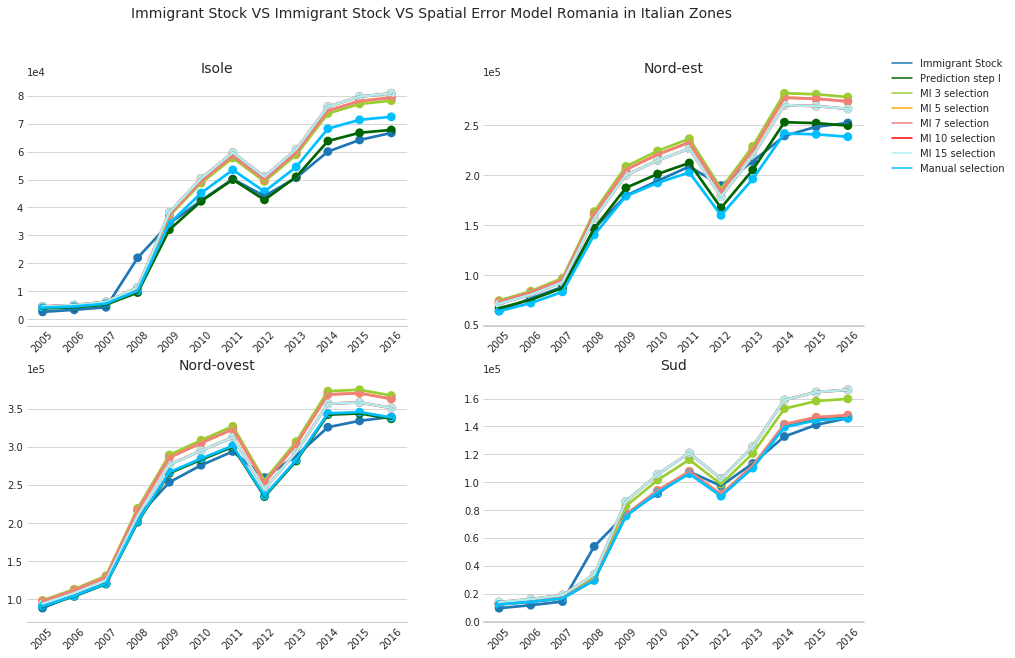

R-squared for Prediction step I 0.993000.
R-squared for MI 3 selection 0.962000.
R-squared for MI 5 selection 0.971000.
R-squared for MI 7 selection 0.971000.
R-squared for MI 10 selection 0.979000.
R-squared for MI 15 selection 0.979000.
R-squared for Manual selection 0.991000.


In [16]:
vars_ = [["Free activities in voluntary associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association", "reach_difficulty - Supermarket", 
  "reach_difficulty - Post offices", "Born alive", "Disposable Income", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]
res_pred, res_params = sem.run_model(y, "Romania", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

---------- Step I ----------
Current time: 18:25:03
Optimization terminated successfully.
Current time: 18:25:35
Computational time: 0:00:31.811983
---------- Step II ----------
---------- Validation ----------


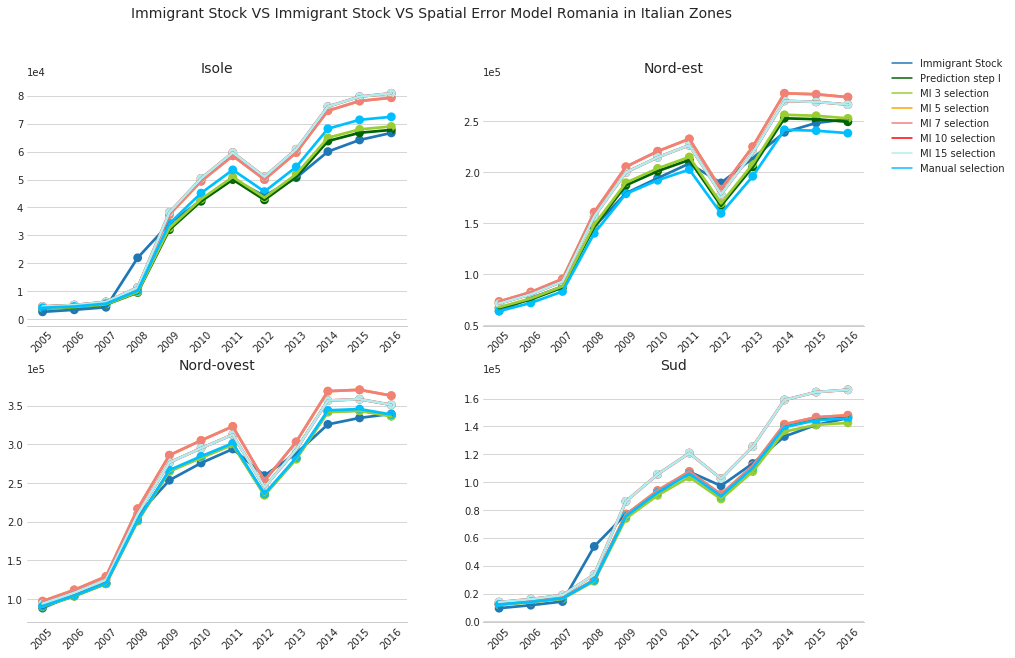

R-squared for Prediction step I 0.993000.
R-squared for MI 3 selection 0.993000.
R-squared for MI 5 selection 0.971000.
R-squared for MI 7 selection 0.971000.
R-squared for MI 10 selection 0.979000.
R-squared for MI 15 selection 0.979000.
R-squared for Manual selection 0.991000.


In [15]:
res_pred, res_params = sem.run_model(y, "Romania", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, True, palette, "Spatial Error Model", save = False)

### MOROCCO

---------- Step I ----------
Current time: 18:28:08
Optimization terminated successfully.
Current time: 18:30:19
Computational time: 0:02:10.798761
---------- Step II ----------
---------- Validation ----------


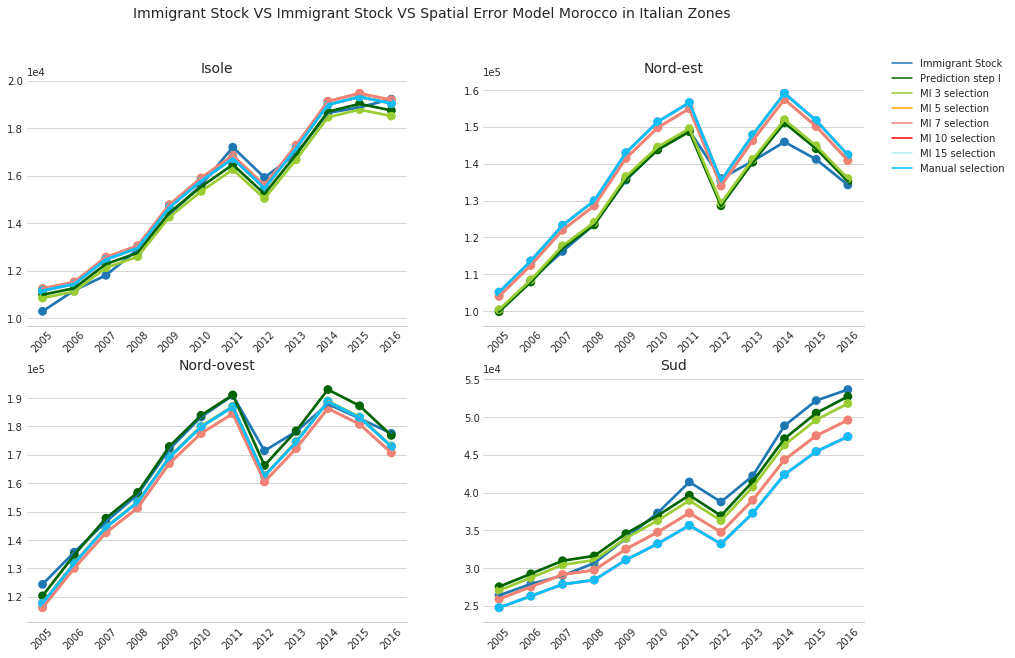

R-squared for Prediction step I 0.999000.
R-squared for MI 3 selection 0.998000.
R-squared for MI 5 selection 0.995000.
R-squared for MI 7 selection 0.995000.
R-squared for MI 10 selection 0.994000.
R-squared for MI 15 selection 0.994000.
R-squared for Manual selection 0.994000.


In [17]:
vars_ = [["Free activities in voluntary associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association", "reach_difficulty - Supermarket", 
  "reach_difficulty - Post offices", "Born alive", "Disposable Income", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]
res_pred, res_params = sem.run_model(y, "Morocco", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

---------- Step I ----------
Current time: 18:30:35
Optimization terminated successfully.
Current time: 18:32:35
Computational time: 0:02:00.527566
---------- Step II ----------
---------- Validation ----------


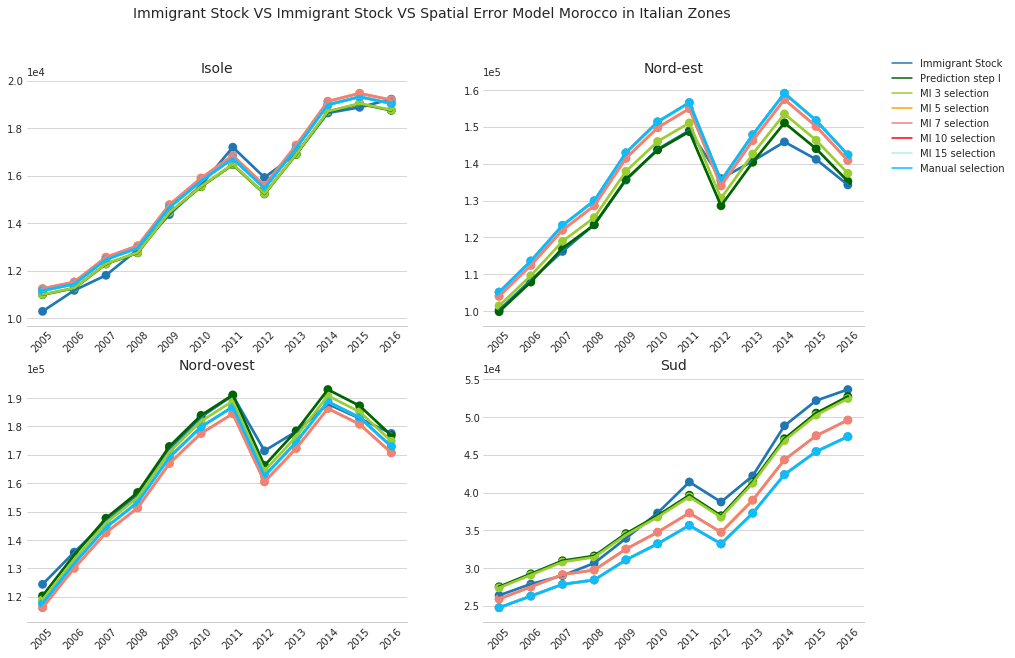

R-squared for Prediction step I 0.999000.
R-squared for MI 3 selection 0.998000.
R-squared for MI 5 selection 0.995000.
R-squared for MI 7 selection 0.995000.
R-squared for MI 10 selection 0.994000.
R-squared for MI 15 selection 0.994000.
R-squared for Manual selection 0.994000.


In [18]:
res_pred, res_params = sem.run_model(y, "Morocco", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, True, palette, "Spatial Error Model", save = False)

### ALBANIA

In [19]:
vars_ = [["native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Disposable Income", 
  "political_info - Every day"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Born alive", "Disposable Income", 
  "political_info - Every day", "reach_difficulty - Supermarket"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "political_info - Never", 
  "political_info - Some times in a week", "Pay money to an association", "reach_difficulty - Supermarket", 
  "reach_difficulty - Pharmacy", "Born alive", "Disposable Income", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

---------- Step I ----------
Current time: 18:32:52
Optimization terminated successfully.
Current time: 18:34:11
Computational time: 0:01:18.777792
---------- Step II ----------
---------- Validation ----------


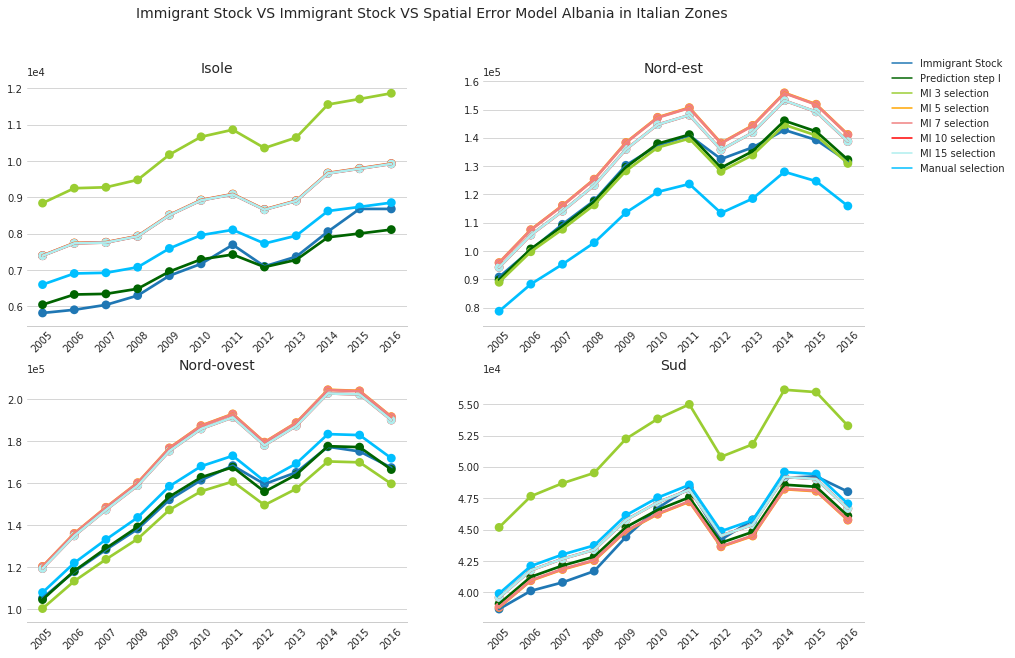

R-squared for Prediction step I 1.000000.
R-squared for MI 3 selection 0.993000.
R-squared for MI 5 selection 0.957000.
R-squared for MI 7 selection 0.958000.
R-squared for MI 10 selection 0.964000.
R-squared for MI 15 selection 0.964000.
R-squared for Manual selection 0.981000.


In [20]:
res_pred, res_params = sem.run_model(y, "Albania", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

In [ ]:
res_pred, res_params = sem.run_model(y, "Albania", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, True, palette, "Spatial Error Model", save = False)

---------- Step I ----------
Current time: 18:35:05


### TUNISIA

---------- Step I ----------
Current time: 11:13:56
Optimization terminated successfully.
Current time: 11:15:40
Computational time: 0:01:44.375296
---------- Step II ----------
---------- Validation ----------


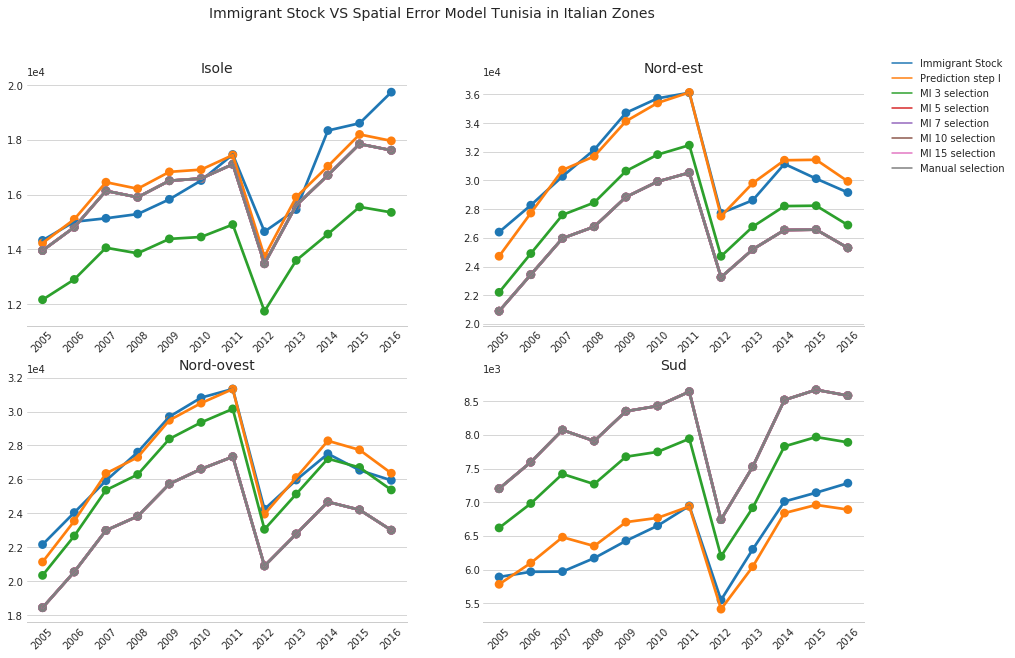

In [23]:
vars_ = [["Pay money to an association"], 
 ["Pay money to an association", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Pay money to an association", 
  "Meetings in cultural, recreational or other associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Post offices", 
  "political_info - Never", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Never", "Pay money to an association", "reach_difficulty - Pharmacy", 
  "reach_difficulty - Post offices", "Born alive", "Accommodation and catering services", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]
res_pred, res_params = sem.run_model(y, "Tunisia", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

---------- Step I ----------
Current time: 11:15:49
Optimization terminated successfully.
Current time: 11:17:26
Computational time: 0:01:37.625306
---------- Step II ----------
---------- Validation ----------


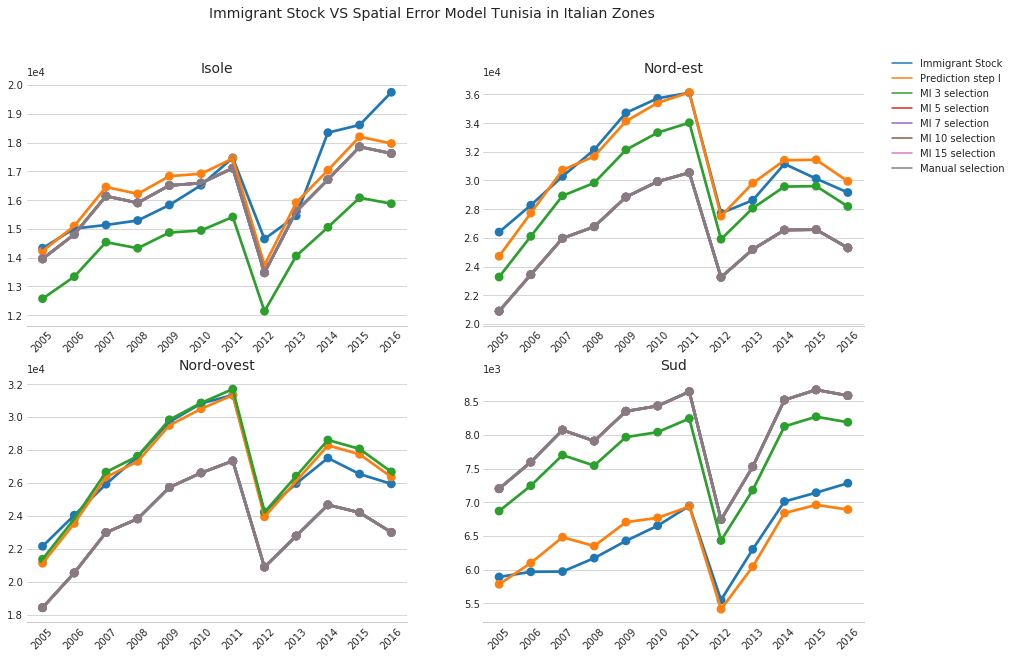

In [24]:
res_pred, res_params = sem.run_model(y, "Tunisia", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, True, palette, "Spatial Error Model", save = False)

### EGYPT

---------- Step I ----------
Current time: 11:22:42
Optimization terminated successfully.
Current time: 11:25:51
Computational time: 0:03:09.016524
---------- Step II ----------
---------- Validation ----------


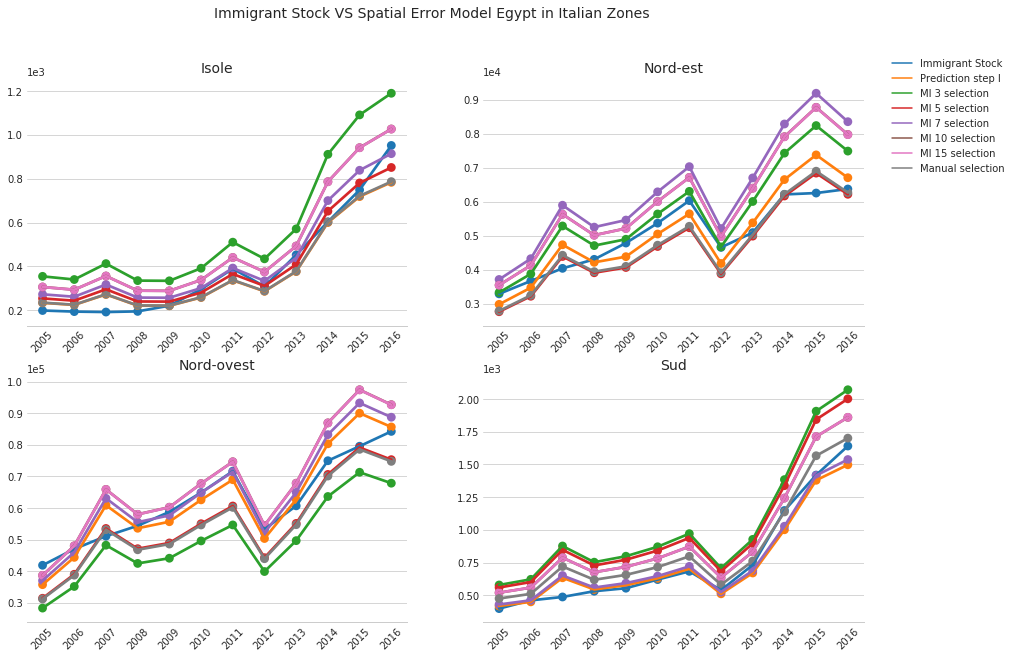

In [25]:
vars_ = [["native population - Total"], 
 ["Pay money to an association", "Non food", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Pay money to an association", 
  "Non food"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Non food", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Post offices", 
  "internal_migration - Italy", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Non food", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "Other goods and services", "Pay money to an association", "Communications", 
  "reach_difficulty - Post offices", "Food and non-alcoholic beverages", 
  "Accommodation and catering services", "Transport"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]
res_pred, res_params = sem.run_model(y, "Egypt", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

In [ ]:
res_pred, res_params = sem.run_model(y, "Egypt", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, True, palette, "Spatial Error Model", save = False)

### ECUADOR

In [ ]:
vars_ = [["native population - Total"], 
 ["Pay money to an association", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Pay money to an association", 
  "reach_difficulty - Post offices"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Accommodation and catering services", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Post offices", 
  "internal_migration - Italy", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Non food", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "Other goods and services", "Pay money to an association", "Disposable Income", 
  "reach_difficulty - Post offices", "reach_difficulty - Supermarket", 
  "Accommodation and catering services", "Transport"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]
res_pred, res_params = sem.run_model(y, "Ecuador", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

In [ ]:
res_pred, res_params = sem.run_model(y, "Ecuador", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, True, palette, "Spatial Error Model", save = False)

### PERU

In [ ]:
vars_ = [["native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Pay money to an association", 
  "Disposable Income"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Disposable Income", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Post offices", 
  "internal_migration - Italy", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Non food", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "Disposable Income", "Pay money to an association", "Born alive", 
  "reach_difficulty - Post offices", "reach_difficulty - Supermarket", 
  "Free activities in non voluntary associations", "Transport"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "political_info - Every day", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]
res_pred, res_params = sem.run_model(y, "Peru", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

In [ ]:
res_pred, res_params = sem.run_model(y, "Peru", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, True, palette, "Spatial Error Model", save = False)

### CHINA

In [ ]:
vars_ = [["Born alive"], 
 ["Born alive", "internal_migration - Foreign country", 
  "political_info - Some times in a week"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "Born alive", "political_info - Some times in a week", 
  "reach_difficulty - Pharmacy"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "reach_difficulty - Post offices", "Born alive", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Pharmacy", 
  "political_info - Some times in a week", "political_info - Every day"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "reach_difficulty - Post offices", "Born alive", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Pharmacy", 
  "political_info - Some times in a week", "political_info - Every day", "native population - Total", 
  "reach_difficulty - Emergency room", "Disposable Income", "Pay money to an association", 
  "Average age of fathers at birth"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]
res_pred, res_params = sem.run_model(y, "China", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

In [ ]:
res_pred, res_params = sem.run_model(y, "China", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, True, palette, "Spatial Error Model", save = False)

### PHILIPPINES

In [ ]:
vars_ = [["native population - Total"], 
 ["Other goods and services", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Other goods and services", "internal_migration - Foreign country", 
  "native population - Total", "Communications", 
  "Non food"], 
 ["Other goods and services", "internal_migration - Foreign country", 
  "native population - Total", "Communications", 
  "Non food", "Housing, water, electricity, gas and other fuels", "Accommodation and catering services", 
  "Free activities in voluntary associations"], 
 ["Other goods and services", "internal_migration - Foreign country", 
  "native population - Total", "Communications", 
  "Non food", "Housing, water, electricity, gas and other fuels", "Accommodation and catering services", 
  "Free activities in voluntary associations", "reach_difficulty - Post offices" "Born alive", 
  "Food and non-alcoholic beverages", "Pay money to an association", "Average age of fathers at birth"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]
res_pred, res_params = sem.run_model(y, "Philippines", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

In [ ]:
res_pred, res_params = sem.run_model(y, "Philippines", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, True, palette, "Spatial Error Model", save = False)